In [1]:
# Importing libraries
from pprint import pprint
import pandas as pd  
import numpy as np  
import itertools
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
%matplotlib inline
import pandas_datareader as pdr
import datetime 
import yfinance as yf
import statsmodels.api as sm
import statistics
import seaborn as sns
from scipy import stats
from scipy.stats import laplace
from scipy.stats import norm
from scipy.stats import kurtosis
import random
from scipy.stats import skew 
import pylab as pl
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import datasets
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn import mixture as mix
from sklearn import metrics
import operator
from nsepy import get_history
from datetime import date
from sklearn.model_selection import KFold
from nsetools import Nse
import talib

In [3]:
class stock:
    
    def __init__(self,symbol,):
        
        self.symbol=symbol
  
    def historical_data(self):
        
        df=pdr.get_data_yahoo(self.symbol, start=datetime.datetime(2008, 1, 1), end=datetime.datetime.today())[['Open','High', 'Low','Adj Close']]
        
        return df

In [4]:
df=stock('^NSEI')
df=df.historical_data()
df= df['Adj Close']
df

Date
2008-01-01     6144.350098
2008-01-02     6179.399902
2008-01-03     6178.549805
2008-01-04     6274.299805
2008-01-07     6279.100098
                  ...     
2020-10-05    11503.349609
2020-10-06    11662.400391
2020-10-07    11738.849609
2020-10-08    11834.599609
2020-10-09    11914.200195
Name: Adj Close, Length: 3120, dtype: float64

C:\Users\DeepakShenoy\anaconda3-new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\DeepakShenoy\anaconda3-new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Text(0.5, 1.0, 'RSI indicator backtest with 14 period')

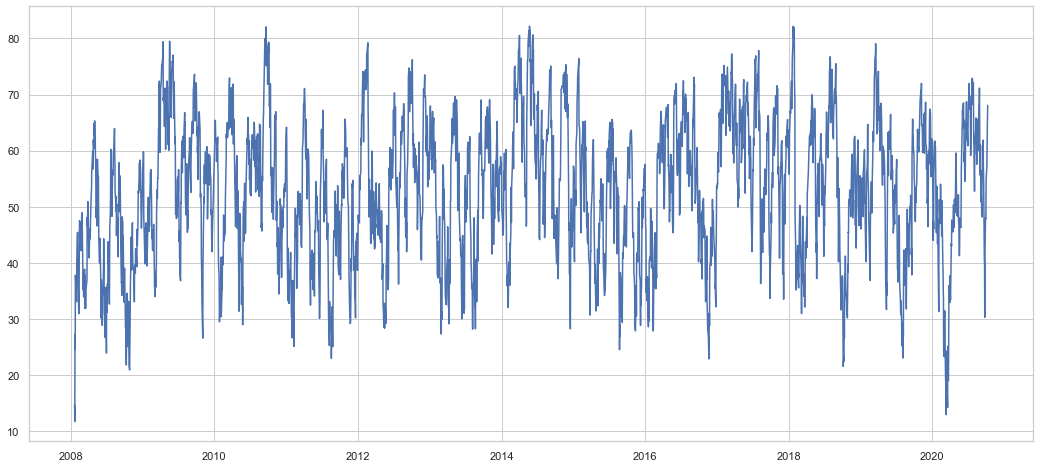

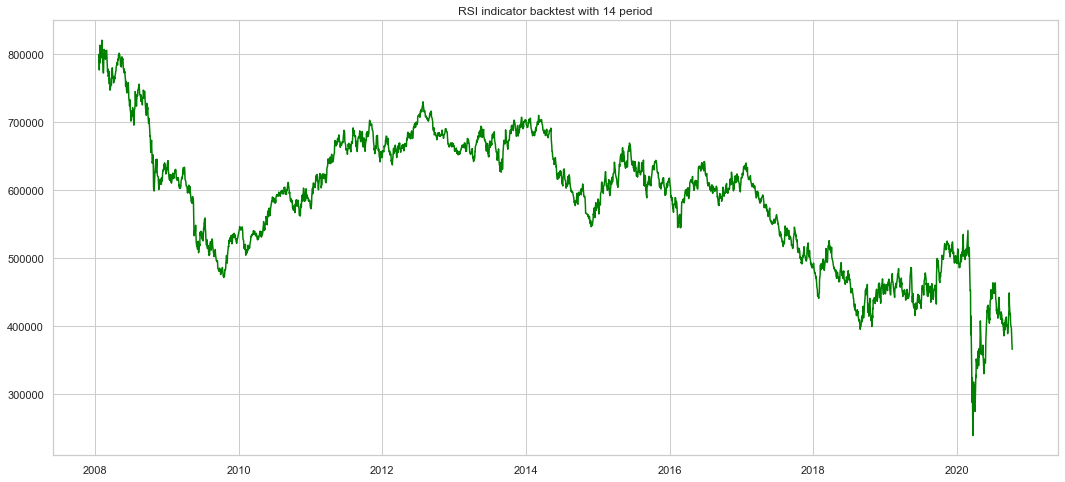

In [11]:
n=14
rsi=talib.RSI(df, timeperiod=n)
sns.set(style="whitegrid")
plt.figure(figsize=(18,8))
plt.plot(rsi)

df_backtest=pd.concat([df, rsi], axis=1)
df_backtest.columns=['close','rsi']
df_backtest['prev_close']=df_backtest['close'].shift(1)
df_backtest['change'] = df_backtest['close'].sub(df_backtest['prev_close'])
df_backtest = df_backtest.dropna()

df_backtest['rsi_signal_buy_entry']=np.where( df_backtest['rsi'] <=30 ,1,0)

df_backtest['buy_exit']=np.where( df_backtest['rsi'] >=70 ,1,0)

df_backtest['buy_position']=0

for i in range(len(df_backtest)):
    
    if (df_backtest['rsi_signal_buy_entry'].iloc[i] ==0 and df_backtest['buy_exit'].iloc[i] ==1) and (df_backtest['buy_position'].iloc[i-1] =='postion_live'):
        
        df_backtest['buy_position'].iloc[i]='no_position'
        
    elif (df_backtest['rsi_signal_buy_entry'].iloc[i] ==1 and df_backtest['buy_exit'].iloc[i] ==0) or (df_backtest['buy_position'].iloc[i-1] =='postion_live') :
        
         df_backtest['buy_position'].iloc[i]='postion_live'
            
    else :
        
        df_backtest['buy_position'].iloc[i]='no_position'


df_backtest['rsi_signal_sell_entry']=np.where( df_backtest['rsi']  >=70,1,0)

df_backtest['sell_exit']=np.where( df_backtest['rsi'] <=30 ,1,0)

df_backtest['sell_position']=0


for i in range(len(df_backtest)):
    
    if (df_backtest['rsi_signal_sell_entry'].iloc[i] ==0 and df_backtest['sell_exit'].iloc[i] ==1) and (df_backtest['sell_position'].iloc[i-1] =='postion_live'):
        
        df_backtest['sell_position'].iloc[i]='no_position'
        
    elif (df_backtest['rsi_signal_sell_entry'].iloc[i] ==1 and df_backtest['sell_exit'].iloc[i] ==0) or (df_backtest['sell_position'].iloc[i-1] =='postion_live') :
        
         df_backtest['sell_position'].iloc[i]='postion_live'
            
    else :
        
        df_backtest['sell_position'].iloc[i]='no_position'


df_backtest['buy_signal']=np.where(df_backtest['buy_position'] =='postion_live', 1 , 0)
df_backtest['sell_signal']=np.where(df_backtest['sell_position'] =='postion_live', -1 , 0)
df_backtest['signal']= df_backtest['buy_signal'].add(df_backtest['sell_signal'])

lot_size=75

df_backtest['Portfolio_Margin']=0

for i in range(len(df_backtest)):
    
    if i==0:
        
        df_backtest['Portfolio_Margin'].iloc[i] =8_00_000
    
    elif df_backtest['signal'].iloc[i] ==1:
        
        df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1] + (df_backtest['change'].iloc[i]*lot_size)
        
    elif df_backtest['signal'].iloc[i] ==-1:
        
        df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1] + (-1*df_backtest['change'].iloc[i]*lot_size)
        
    else:
         df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1]

sns.set(style="whitegrid")
plt.figure(figsize=(18,8))
plt.plot( df_backtest['Portfolio_Margin'], color='green')
plt.title(f"RSI indicator backtest with {n} period")

C:\Users\DeepakShenoy\anaconda3-new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\DeepakShenoy\anaconda3-new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


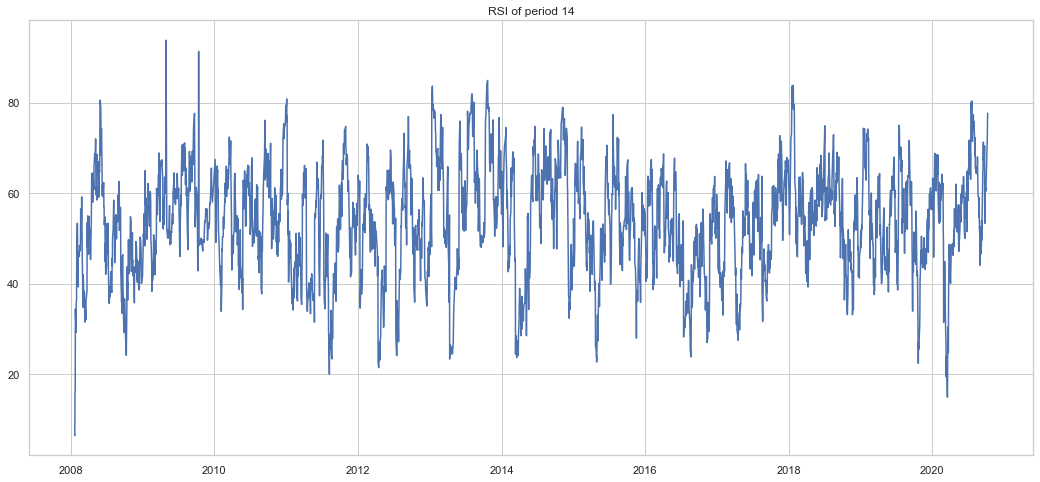

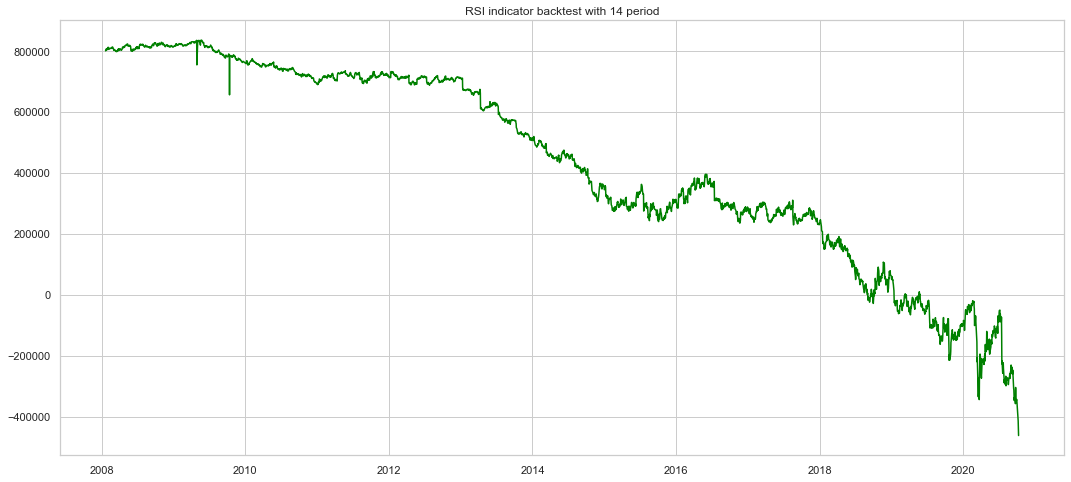

In [21]:
df=stock('INFY.NS')
df=df.historical_data()
df= df['Adj Close']
lot_size=1200
    
def RSI(period,lot_size):
    
    n=period
    rsi=talib.RSI(df, timeperiod=n)
    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot(rsi)
    plt.title(f"RSI of period {n}")

    df_backtest=pd.concat([df, rsi], axis=1)
    df_backtest.columns=['close','rsi']
    df_backtest['prev_close']=df_backtest['close'].shift(1)
    df_backtest['change'] = df_backtest['close'].sub(df_backtest['prev_close'])
    df_backtest = df_backtest.dropna()

    df_backtest['rsi_signal_buy_entry']=np.where( df_backtest['rsi'] <=30 ,1,0)

    df_backtest['buy_exit']=np.where( df_backtest['rsi'] >=70 ,1,0)

    df_backtest['buy_position']=0

    for i in range(len(df_backtest)):
        
        if (df_backtest['rsi_signal_buy_entry'].iloc[i] ==0 and df_backtest['buy_exit'].iloc[i] ==1) and (df_backtest['buy_position'].iloc[i-1] =='postion_live'):
            
            df_backtest['buy_position'].iloc[i]='no_position'
        
        elif (df_backtest['rsi_signal_buy_entry'].iloc[i] ==1 and df_backtest['buy_exit'].iloc[i] ==0) or (df_backtest['buy_position'].iloc[i-1] =='postion_live') :
            
            df_backtest['buy_position'].iloc[i]='postion_live'
            
        else :
            
            df_backtest['buy_position'].iloc[i]='no_position'

    
    df_backtest['rsi_signal_sell_entry']=np.where( df_backtest['rsi']  >=70,1,0)

    df_backtest['sell_exit']=np.where( df_backtest['rsi'] <=30 ,1,0)

    df_backtest['sell_position']=0


    for i in range(len(df_backtest)):
        
        if (df_backtest['rsi_signal_sell_entry'].iloc[i] ==0 and df_backtest['sell_exit'].iloc[i] ==1) and (df_backtest['sell_position'].iloc[i-1] =='postion_live'):
            
            df_backtest['sell_position'].iloc[i]='no_position'
        
        elif (df_backtest['rsi_signal_sell_entry'].iloc[i] ==1 and df_backtest['sell_exit'].iloc[i] ==0) or (df_backtest['sell_position'].iloc[i-1] =='postion_live') :
            
            df_backtest['sell_position'].iloc[i]='postion_live'
            
        else :
            
            df_backtest['sell_position'].iloc[i]='no_position'


   
    df_backtest['buy_signal']=np.where(df_backtest['buy_position'] =='postion_live', 1 , 0)
    df_backtest['sell_signal']=np.where(df_backtest['sell_position'] =='postion_live', -1 , 0)
    df_backtest['signal']= df_backtest['buy_signal'].add(df_backtest['sell_signal'])

    df_backtest['Portfolio_Margin']=0

    for i in range(len(df_backtest)):
        
        if i==0:
            
            df_backtest['Portfolio_Margin'].iloc[i] =8_00_000
    
        elif df_backtest['signal'].iloc[i] ==1:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1] + (df_backtest['change'].iloc[i]*lot_size)
        
        elif df_backtest['signal'].iloc[i] ==-1:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1] + (-1*df_backtest['change'].iloc[i]*lot_size)
        
        else:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1]

    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot( df_backtest['Portfolio_Margin'], color='green')
    plt.title(f"RSI indicator backtest with {n} period")
    
    return

RSI(14,lot_size)

In [217]:
# df_backtest.to_csv(r"C:\Users\DeepakShenoy\Desktop\Quantitative Research\Short_Sell\df_backtest.csv")

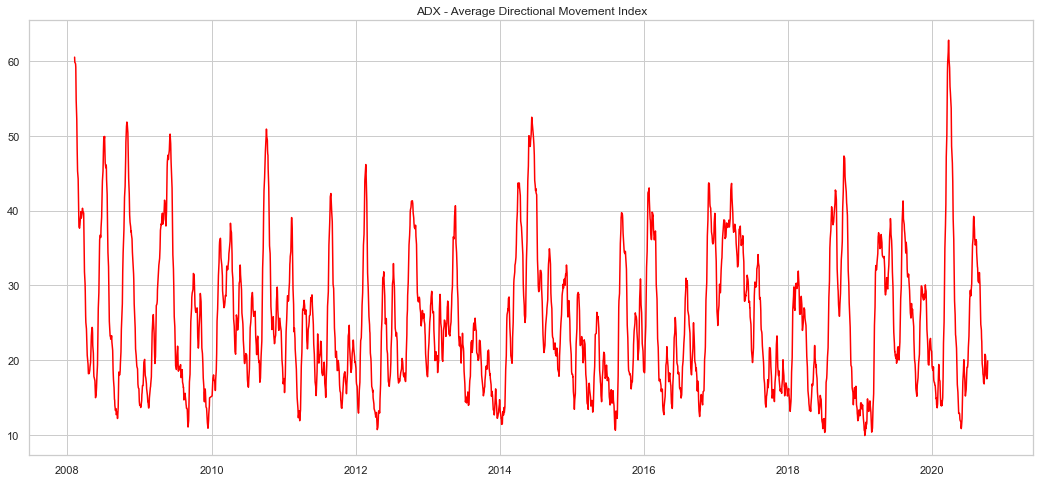

In [6]:
def ADX(period):
    df_adx=stock('^NSEI')
    df_adx=df_adx.historical_data()
    df_adx=df_adx[['High','Low','Adj Close']]

    ti_adx= talib.ADX(df_adx['High'], df_adx['Low'], df_adx['Adj Close'], timeperiod=period)
    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot(ti_adx, color='red')
    plt.title(f"ADX - Average Directional Movement Index")
    
    return

ADX(14)

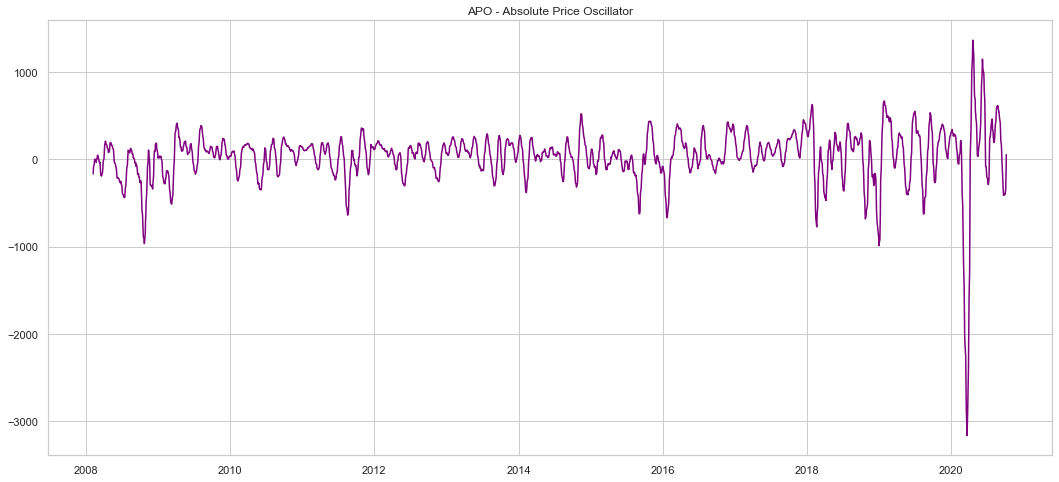

In [7]:
def APO():
    
    df_apo=stock('^DJI')
    df_apo=df_apo.historical_data()
    df_apo=df_apo['Adj Close']
    
    ti_apo =talib.APO(df_apo, fastperiod=12, slowperiod=26, matype=0)
    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot(ti_apo, color='purple')
    plt.title("APO - Absolute Price Oscillator")
    
    return

APO()

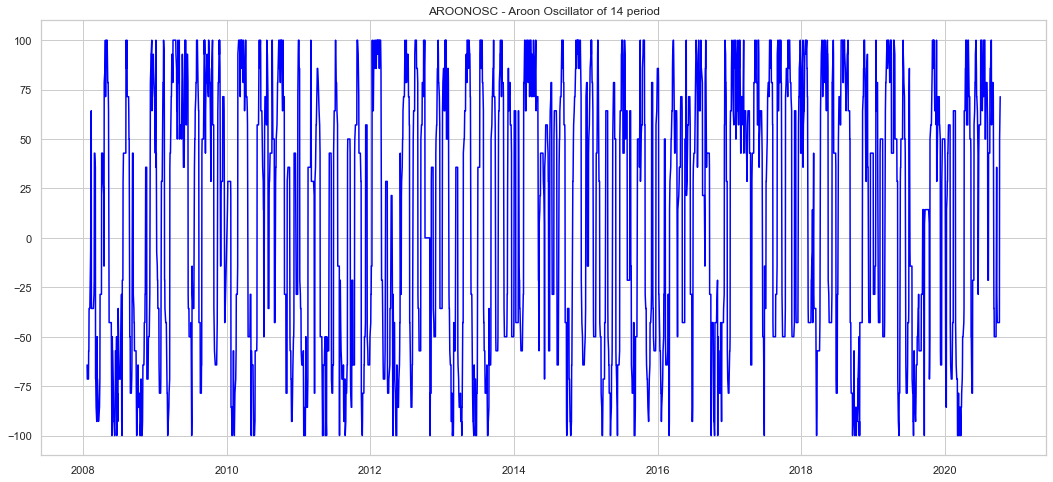

In [8]:
def AROONOSC(period):
    
    df_aroon=stock('^NSEI')
    df_aroon=df_aroon.historical_data()
    df_aroon=df_aroon[['High','Low']]
    
    tai_aroon=talib.AROONOSC( df_aroon['High'], df_aroon['Low'] , timeperiod=period)
    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot(tai_aroon, color='blue')
    plt.title(f"AROONOSC - Aroon Oscillator of {period} period")
    
    return

AROONOSC(14)

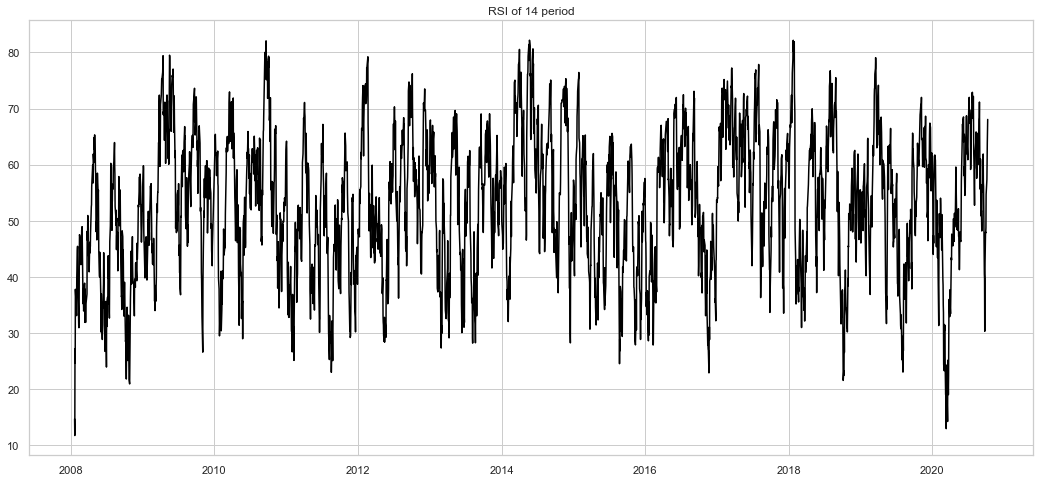

In [9]:
def RSI(period):
    
    df_rsi=stock('^NSEI')
    df_rsi=df_rsi.historical_data()
    df_rsi=df_rsi['Adj Close']
    
    rsi=talib.RSI(df_rsi, timeperiod=n)
    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot(rsi, color='black')
    plt.title(f"RSI of {period} period")
    
    return 

RSI(14)

C:\Users\DeepakShenoy\anaconda3-new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\DeepakShenoy\anaconda3-new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,close,William,prev_close,change,william_signal_buy_entry,buy_exit,buy_position,william_signal_sell_entry,sell_exit,sell_position,buy_signal,sell_signal,signal,Portfolio_Margin
Date,,,,,,,,,,,,,,
2020-10-05,11503.349609,-13.860379,11416.950195,86.399414,0,1,no_position,1,0,postion_live,0,-1,-1,-1.644014e+06
2020-10-06,11662.400391,-2.010945,11503.349609,159.050781,0,1,no_position,1,0,postion_live,0,-1,-1,-1.655942e+06
2020-10-07,11738.849609,-2.487558,11662.400391,76.449219,0,1,no_position,1,0,postion_live,0,-1,-1,-1.661676e+06
2020-10-08,11834.599609,-6.373876,11738.849609,95.750000,0,1,no_position,1,0,postion_live,0,-1,-1,-1.668857e+06
2020-10-09,11914.200195,-2.124645,11834.599609,79.600586,0,1,no_position,1,0,postion_live,0,-1,-1,-1.674827e+06


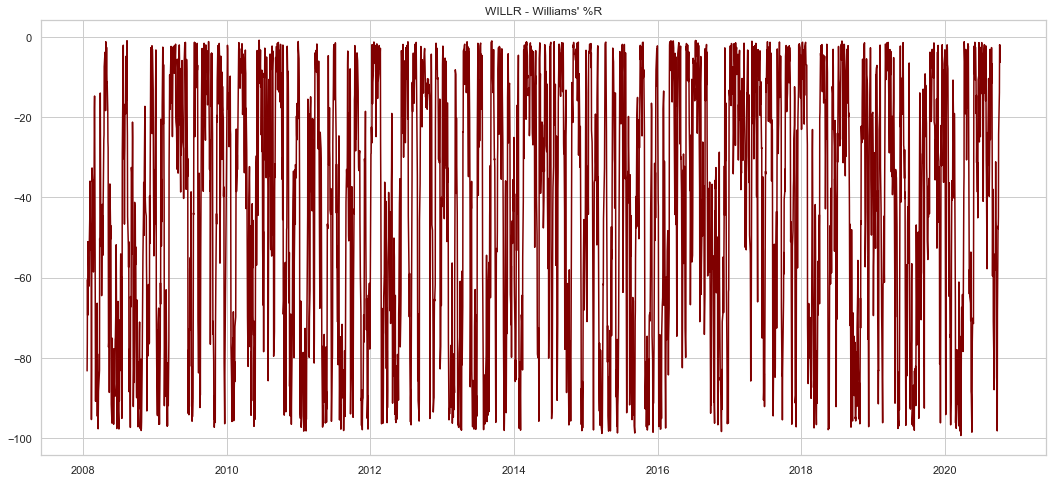

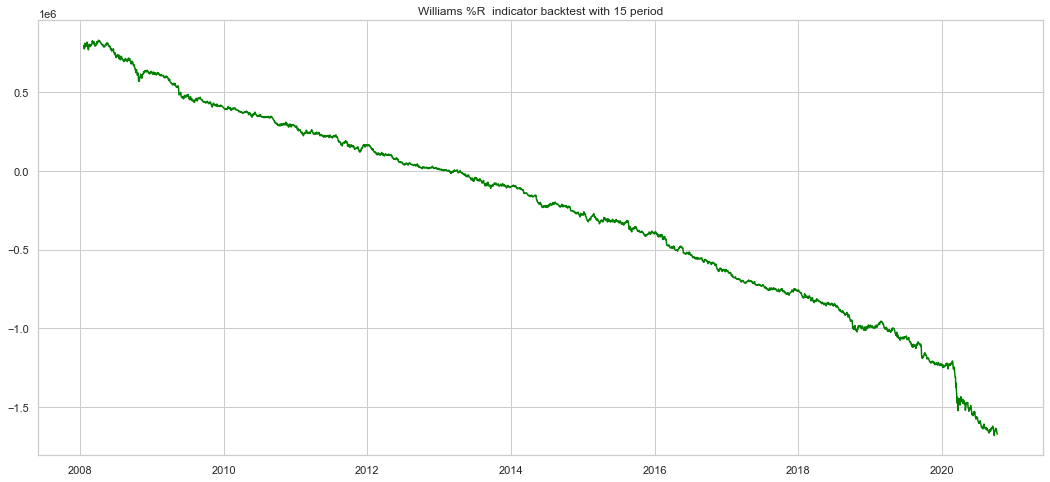

In [18]:
def WILLIAMS(period,lot_size):
    
    df=stock('^NSEI')
    df=df.historical_data()
    df=df[['High','Low','Adj Close']]

    wri= talib.WILLR(df['High'], df['Low'], df['Adj Close'], timeperiod=period)
    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot(wri, color='maroon')
    plt.title(f"WILLR - Williams' %R")
    
    df_backtest=pd.concat([df['Adj Close'], wri], axis=1)
    df_backtest.columns=['close','William']
    df_backtest['prev_close']=df_backtest['close'].shift(1)
    df_backtest['change'] = df_backtest['close'].sub(df_backtest['prev_close'])
    df_backtest = df_backtest.dropna()

    df_backtest['william_signal_buy_entry']=np.where( df_backtest['William'] <=-80 ,1,0)

    df_backtest['buy_exit']=np.where( df_backtest['William'] >=-20 ,1,0)

    df_backtest['buy_position']=0

    for i in range(len(df_backtest)):
        
        if (df_backtest['william_signal_buy_entry'].iloc[i] ==0 and df_backtest['buy_exit'].iloc[i] ==1) and (df_backtest['buy_position'].iloc[i-1] =='postion_live'):
            
            df_backtest['buy_position'].iloc[i]='no_position'
        
        elif (df_backtest['william_signal_buy_entry'].iloc[i] ==1 and df_backtest['buy_exit'].iloc[i] ==0) or (df_backtest['buy_position'].iloc[i-1] =='postion_live') :
            
            df_backtest['buy_position'].iloc[i]='postion_live'
            
        else :
            
            df_backtest['buy_position'].iloc[i]='no_position'

    
    df_backtest['william_signal_sell_entry']=np.where( df_backtest['William']  >=-20,1,0)

    df_backtest['sell_exit']=np.where( df_backtest['William'] <=-80 ,1,0)

    df_backtest['sell_position']=0


    for i in range(len(df_backtest)):
        
        if (df_backtest['william_signal_sell_entry'].iloc[i] ==0 and df_backtest['sell_exit'].iloc[i] ==1) and (df_backtest['sell_position'].iloc[i-1] =='postion_live'):
            
            df_backtest['sell_position'].iloc[i]='no_position'
        
        elif (df_backtest['william_signal_sell_entry'].iloc[i] ==1 and df_backtest['sell_exit'].iloc[i] ==0) or (df_backtest['sell_position'].iloc[i-1] =='postion_live') :
            
            df_backtest['sell_position'].iloc[i]='postion_live'
            
        else :
            
            df_backtest['sell_position'].iloc[i]='no_position'


            

    df_backtest['buy_signal']=np.where(df_backtest['buy_position'] =='postion_live', 1 , 0)
    df_backtest['sell_signal']=np.where(df_backtest['sell_position'] =='postion_live', -1 , 0)
    df_backtest['signal']= df_backtest['buy_signal'].add(df_backtest['sell_signal'])

    df_backtest['Portfolio_Margin']=0

    for i in range(len(df_backtest)):
        
        if i==0:
            
            df_backtest['Portfolio_Margin'].iloc[i] =8_00_000
    
        elif df_backtest['signal'].iloc[i] ==1:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1] + (df_backtest['change'].iloc[i]*lot_size)
        
        elif df_backtest['signal'].iloc[i] ==-1:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1] + (-1*df_backtest['change'].iloc[i]*lot_size)
        
        else:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1]

    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot( df_backtest['Portfolio_Margin'], color='green')
    plt.title(f"Williams %R  indicator backtest with {period} period")
    
    
    return df_backtest.tail()

WILLIAMS(15,75)

C:\Users\DeepakShenoy\anaconda3-new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\DeepakShenoy\anaconda3-new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


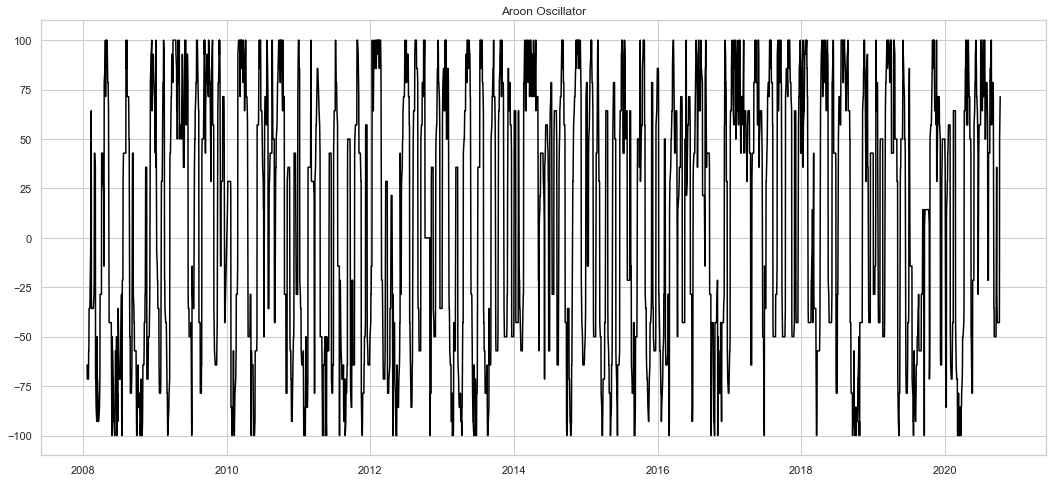

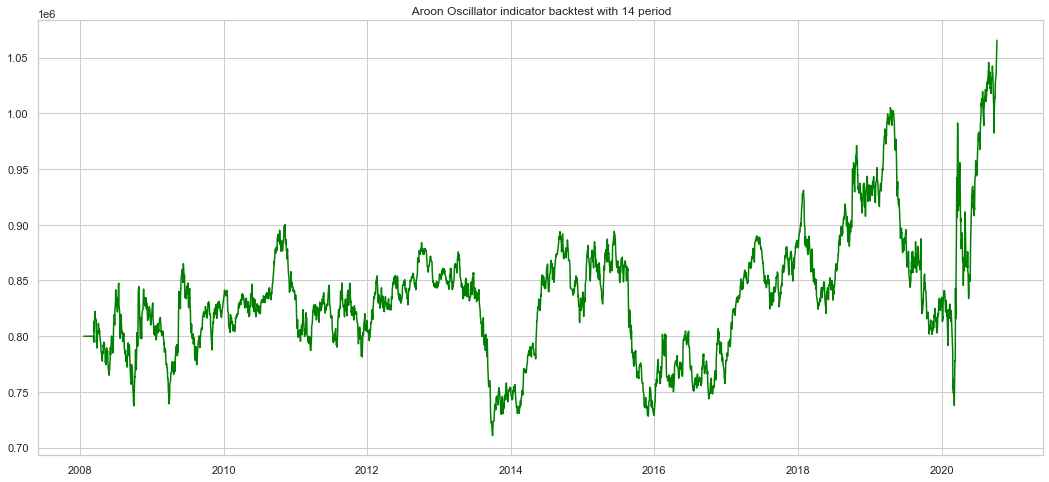

In [48]:
def AROONOSC(period,lot_size):
    
    df=stock('^NSEI')
    df=df.historical_data()
    df=df[['High', 'Low','Adj Close']]

    arronosc= talib.AROONOSC(df['High'], df['Low'] ,timeperiod=period)
    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot(arronosc, color='black')
    plt.title(f"Aroon Oscillator")
    
    df_backtest=pd.concat([df['Adj Close'], arronosc], axis=1)
    df_backtest.columns=['close','arronosc']
    df_backtest['prev_close']=df_backtest['close'].shift(1)
    df_backtest['change'] = df_backtest['close'].sub(df_backtest['prev_close'])
    df_backtest = df_backtest.dropna()

    df_backtest['aroonosc_signal_buy_entry']=np.where( df_backtest['arronosc'] >=90 ,1,0)

    df_backtest['buy_exit']=np.where( df_backtest['arronosc'] <= -90 ,1,0)

    df_backtest['buy_position']=0

    for i in range(len(df_backtest)):
        
        if (df_backtest['aroonosc_signal_buy_entry'].iloc[i] ==0 and df_backtest['buy_exit'].iloc[i] ==1) and (df_backtest['buy_position'].iloc[i-1] =='postion_live'):
            
            df_backtest['buy_position'].iloc[i]='no_position'
        
        elif (df_backtest['aroonosc_signal_buy_entry'].iloc[i] ==1 and df_backtest['buy_exit'].iloc[i] ==0) or (df_backtest['buy_position'].iloc[i-1] =='postion_live') :
            
            df_backtest['buy_position'].iloc[i]='postion_live'
            
        else :
            
            df_backtest['buy_position'].iloc[i]='no_position'

    
    df_backtest['aroonosc_signal_sell_entry']=np.where( df_backtest['arronosc']  <=-90,1,0)

    df_backtest['sell_exit']=np.where( df_backtest['arronosc'] >= 90 ,1,0)

    df_backtest['sell_position']=0


    for i in range(len(df_backtest)):
        
        if (df_backtest['aroonosc_signal_sell_entry'].iloc[i] ==0 and df_backtest['sell_exit'].iloc[i] ==1) and (df_backtest['sell_position'].iloc[i-1] =='postion_live'):
            
            df_backtest['sell_position'].iloc[i]='no_position'
        
        elif (df_backtest['aroonosc_signal_sell_entry'].iloc[i] ==1 and df_backtest['sell_exit'].iloc[i] ==0) or (df_backtest['sell_position'].iloc[i-1] =='postion_live') :
            
            df_backtest['sell_position'].iloc[i]='postion_live'
            
        else :
            
            df_backtest['sell_position'].iloc[i]='no_position'

    df_backtest['buy_signal']=np.where(df_backtest['buy_position'] =='postion_live', 1 , 0)
    df_backtest['sell_signal']=np.where(df_backtest['sell_position'] =='postion_live', -1 , 0)
    df_backtest['signal']= df_backtest['buy_signal'].add(df_backtest['sell_signal'])
    df_backtest['signal']=df_backtest['signal'].shift(1)

    df_backtest['Portfolio_Margin']=0

    for i in range(len(df_backtest)):
        
        if i==0:
            
            df_backtest['Portfolio_Margin'].iloc[i] =8_00_000
    
        elif df_backtest['signal'].iloc[i] ==1:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1] + (df_backtest['change'].iloc[i]*lot_size)
        
        elif df_backtest['signal'].iloc[i] ==-1:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1] + (-1*df_backtest['change'].iloc[i]*lot_size)
        
        else:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1]

    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot( df_backtest['Portfolio_Margin'], color='green')
    plt.title(f" Aroon Oscillator indicator backtest with {period} period")
    
    
    return

AROONOSC(14,75)

C:\Users\DeepakShenoy\anaconda3-new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\DeepakShenoy\anaconda3-new\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


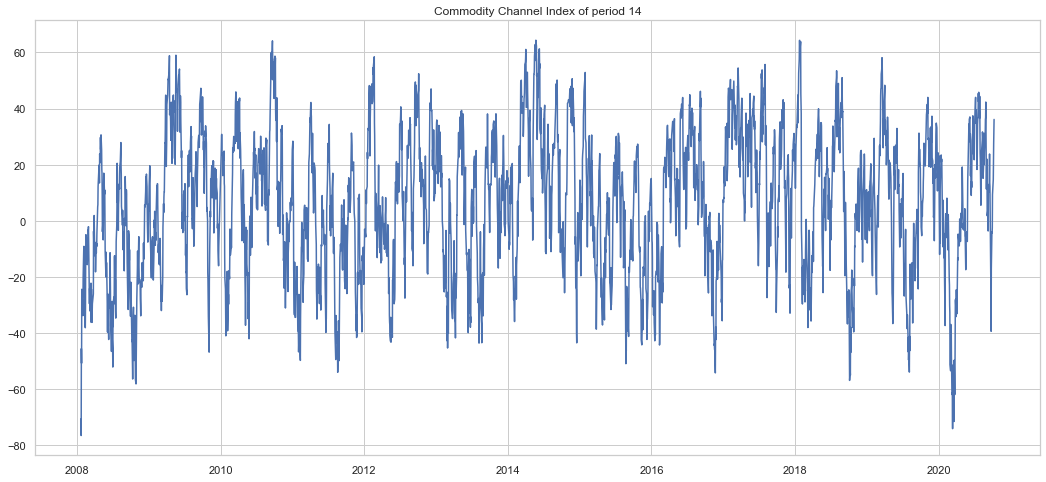

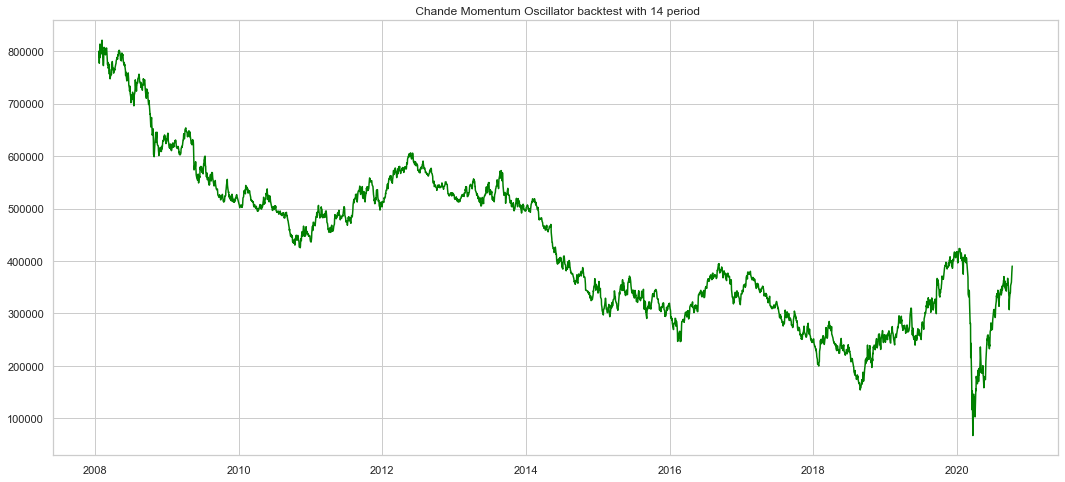

In [55]:
def CMO(period, lot_size):
    
    df=stock('^NSEI')
    df=df.historical_data()
    
    df['CMO']=talib.CMO(df['Adj Close'], timeperiod=period)
    
    """
    PLOT THE Commodity Channel Index of period
    """
    
    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot(df['CMO'])
    plt.title(f"Commodity Channel Index of period {period}")
    
    df_backtest=pd.concat([df['Adj Close'], df['CMO']], axis=1)
    df_backtest.columns=['close','cmo']
    df_backtest['prev_close']=df_backtest['close'].shift(1)
    df_backtest['change'] = df_backtest['close'].sub(df_backtest['prev_close'])
    df_backtest = df_backtest.dropna()
    
    """
    BUY  AND EXIT LOGIC (Buy when CMO goes below -50 and exit above 50)
    """
    df_backtest['cmo_signal_buy_entry']=np.where( df_backtest['cmo'] <= -50 ,1,0)

    df_backtest['buy_exit']=np.where( df_backtest['cmo'] >= 50 ,1,0)

    df_backtest['buy_position']=0

    for i in range(len(df_backtest)):
        
        if (df_backtest['cmo_signal_buy_entry'].iloc[i] ==0 and df_backtest['buy_exit'].iloc[i] ==1) and (df_backtest['buy_position'].iloc[i-1] =='postion_live'):
            
            df_backtest['buy_position'].iloc[i]='no_position'
        
        elif (df_backtest['cmo_signal_buy_entry'].iloc[i] ==1 and df_backtest['buy_exit'].iloc[i] ==0) or (df_backtest['buy_position'].iloc[i-1] =='postion_live') :
            
            df_backtest['buy_position'].iloc[i]='postion_live'
            
        else :
            
            df_backtest['buy_position'].iloc[i]='no_position'
   
    """
    SELL AND EXIT LOGIC (Buy when CMO goes above 50 and exit below -50)
    """
     
    df_backtest['cmo_signal_sell_entry']=np.where( df_backtest['cmo']  >= 50,1,0)

    df_backtest['sell_exit']=np.where( df_backtest['cmo'] <= -50 ,1,0)

    df_backtest['sell_position']=0


    for i in range(len(df_backtest)):
        
        if (df_backtest['cmo_signal_sell_entry'].iloc[i] ==0 and df_backtest['sell_exit'].iloc[i] ==1) and (df_backtest['sell_position'].iloc[i-1] =='postion_live'):
            
            df_backtest['sell_position'].iloc[i]='no_position'
        
        elif (df_backtest['cmo_signal_sell_entry'].iloc[i] ==1 and df_backtest['sell_exit'].iloc[i] ==0) or (df_backtest['sell_position'].iloc[i-1] =='postion_live') :
            
            df_backtest['sell_position'].iloc[i]='postion_live'
            
        else :
            
            df_backtest['sell_position'].iloc[i]='no_position'

    """
    FINAL BUY & SELL SIGNAL
    """
    df_backtest['buy_signal']=np.where(df_backtest['buy_position'] =='postion_live', 1 , 0)
    df_backtest['sell_signal']=np.where(df_backtest['sell_position'] =='postion_live', -1 , 0)
    df_backtest['signal']= df_backtest['buy_signal'].add(df_backtest['sell_signal'])
#     df_backtest['signal']=df_backtest['signal'].shift(1)
     
    """
    Starting portofolio with intial margin of Rs. 8,00,000  and lot size 75, equity is NIFTY FUTURES
    """
    
    df_backtest['Portfolio_Margin']=0

    for i in range(len(df_backtest)):
        
        if i==0:
            
            df_backtest['Portfolio_Margin'].iloc[i] =8_00_000
    
        elif df_backtest['signal'].iloc[i] ==1:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1] + (df_backtest['change'].iloc[i]*lot_size)
        
        elif df_backtest['signal'].iloc[i] ==-1:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1] + (-1*df_backtest['change'].iloc[i]*lot_size)
        
        else:
            
            df_backtest['Portfolio_Margin'].iloc[i] =df_backtest['Portfolio_Margin'].iloc[i-1]
    
    """
    PLOT THE EQUITY CURVE OF BACKTEST
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(18,8))
    plt.plot( df_backtest['Portfolio_Margin'], color='green')
    plt.title(f" Chande Momentum Oscillator backtest with {period} period")
    
    
    return 
                                      
CMO(14,75)

In [ ]:
import datetime
import time
from time import perf_counter
from nsetools import Nse
nse = Nse()

start=time.perf_counter()

second_data=[]

def nifty_live(period, second):
    
    for i in range(period):
    
        live_nifty=nse.get_index_quote("NIFTY 50")
        live_nifty_value=list(live_nifty.values())
        nifty_live=live_nifty_value[1]
        
        second_data.append(nifty_live)
        date_time=datetime.datetime.now()
        
        print(f"Nifty live is {nifty_live} at {date_time}")
        
        time.sleep(second)

nifty_live(5,10)

finish=time.perf_counter()

print(f'finished in {round(finish-start,2)} seconds')

Nifty live is 11940.05 at 2020-10-12 12:34:31.610097
Nifty live is 11940.05 at 2020-10-12 12:34:43.679210
